In [1]:
import tqdm
import torch
import numpy as np
import pandas as pd
from torch import nn, einsum
import seaborn as sns
import scipy.io as sio
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from einops import rearrange, repeat
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# !nvidia-smi
print(torch.cuda.is_available())
print(torch.cuda.current_device())

c:\Users\comparch\anaconda3\envs\CondaPy39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
0


# Small data

In [2]:
import pyedflib
import numpy as np
from scipy import signal
import copy
file_name = "E:/chbmit/chb01/chb01_01.edf"
# file_name = "eeg44.edf"
f = pyedflib.EdfReader(file_name)

In [8]:
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]), dtype=np.float32)
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

data = sigbufs[:, 1500:1500+256*1000]
data = rearrange(data, 'c (h t) -> t h c', c=23,h=256,t=1000)
print(data.shape)
label = np.random.randint(0, 4, 1000)
print(label.shape)

(1000, 256, 23)
(1000,)


# Big Data

In [2]:
sz_data = np.load("sz_big.npy")
pre_data = np.load("omen_big_30.npy")
nm_data = np.load("norm_big.npy")
print(sz_data.shape, pre_data.shape, nm_data.shape)

(22, 2217984) (22, 9753600) (22, 921600)


In [3]:
data = np.concatenate([sz_data, pre_data, nm_data], 1) # (22, 40701, 256)
data = rearrange(data, 'chn (time hz) -> time hz chn', chn=22, hz=256)
print(data.shape)

lab0 = np.full((8664, 1), 0)
lab1 = np.full((38100, 1), 1)
lab2 = np.full((3600, 1), 2)
label = np.concatenate([lab0, lab1, lab2], 0)
print(label.shape)

(50364, 256, 22)
(50364, 1)


In [4]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform

        self.data = data
        self.label = label
        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train, test, train_label, test_label = train_test_split(data, np.array(label),test_size = 0.1,stratify=label, random_state = 0)
print('train data:',len(train))
print('test data:',len(test))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=True)

print(data.shape)

train data: 45327
test data: 5037
(50364, 256, 22)


# GRU GRU

In [5]:
# GRU
class CPC(nn.Module):
    def __init__ (self, input_layer,hidden_layer, n_layer, num_class,group, time_step):
        super().__init__()
        
        self.time_step = time_step # k  ___learn___{   len=time_step   }
        # input size: (Bch, len, chnl)
        # nn.GRU: (in=chnl, out=>chnl2, GRU layers)
        self.gru_first = nn.GRU(22, 128, 3, batch_first = True)#(bs, 256, 22) -> (bs, 256, 128)
   
        self.gru = nn.GRU(input_layer,hidden_layer,n_layer,batch_first = True)
        
        self.dec = nn.ModuleList([nn.Linear(hidden_layer,128) for i in range(time_step)])# k=T, could!=, 
        
        self.mlp_head = nn.Linear(hidden_layer,num_class)
        
        self.softmax = nn.Softmax(dim=1)
        
        self.lsoftmax = nn.LogSoftmax(dim=1) # loss func 


    def forward(self,x):
        batch = x.shape[0] 
                
        t_samples = 32 # where to start: ___learn___{ }____pred____

        z,__ = self.gru_first(x) # z:(bs, 256, 128)
        
        nce = 0
        
        encoder_sample = torch.empty((self.time_step,batch,128)).float() # Z_{t+k}; ()
        
        for i in np.arange(1,self.time_step+1):
            encoder_sample[i-1] = z[:,t_samples+i,:].view(batch,128) #from start to start+k
        
        forward_seq = z[:,:t_samples+1,:] # Z_{t}, {  forward_seq  }_____pred______
        
        output,hidden = self.gru(forward_seq) # decrease dim, (bs, 256-128, 128) --> (bs, 256-128, 64)
        c_t = output[:,t_samples,:].view(batch,64)# at T time, (bs, 128th, 64) --> (bs, 64)
        
        pred = torch.empty((self.time_step,batch,128)).float() # W_{k}C_{t}, empty(128, bs, 128)
        for i in np.arange(0,self.time_step): # do time_step=128 times linear
            linear = self.dec[i]
            pred[i] = linear(c_t) # (bs, 64)--> (bs, 128)
        for i in np.arange(0,self.time_step):
            total = torch.mm(encoder_sample[i], torch.transpose(pred[i],0,1)) # positive samples
            correct = torch.sum(torch.eq(torch.argmax(self.softmax(total),dim=0),torch.arange(0,batch))) # pred, label
            nce += torch.sum(torch.diag(self.lsoftmax(total)))
        nce /= -1.*batch*self.time_step
        acc = 1.*correct.item()/batch
        
        out = self.mlp_head(output[:,-1,:]) #for cls, ct or zt is ok.
        return acc,nce,out
        

In [10]:
DEVICE = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
CPC_model = CPC(
    input_layer=128, # LSTM input
    hidden_layer=64, # LSTM dim
    n_layer=3, # LSTM layers
    num_class=5, # no use
    group=5, # wave band, no use
    time_step= 12, # k, how long future you will predict
).to(DEVICE)

print(DEVICE)
total = sum(p.numel() for p in CPC_model.parameters())
print(CPC_model)
print(total)

optimizer = torch.optim.AdamW(CPC_model.parameters(), lr = 1e-3)

cuda:0
CPC(
  (gru_first): GRU(22, 128, num_layers=3, batch_first=True)
  (gru): GRU(128, 64, num_layers=3, batch_first=True)
  (dec): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Linear(in_features=64, out_features=128, bias=True)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): Linear(in_features=64, out_features=128, bias=True)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): Linear(in_features=64, out_features=128, bias=True)
    (10): Linear(in_features=64, out_features=128, bias=True)
    (11): Linear(in_features=64, out_features=128, bias=True)
  )
  (mlp_head): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
  (lsoftmax): LogSoftma

# Classification

In [11]:
EPOCH = 30
train_times = 0

loss_list=[]
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    for  _, (inputs, labels) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)   # casting to long
        labels = labels.to(DEVICE)

        acc, nce_loss, outputs = CPC_model(inputs)
        loss = F.cross_entropy(outputs, labels.squeeze()) # .squeeze()
        loss2 = nce_loss
        losses = loss+nce_loss
        losses.backward()
        optimizer.step() 
        running_loss += losses.item()
        count = count+1
    loss_loss = running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)

    with torch.no_grad():
        count =0
        running_loss=0.0
        pre = list()
        lab = list()
        for  _, (inputs, labels) in enumerate(test_dataloader, 0):
            inputs = inputs.to(DEVICE)
            labels = labels.type(torch.LongTensor)   # casting to long
            labels = labels.to(DEVICE)

            _,_,outputs = CPC_model(inputs)

            loss = F.cross_entropy(outputs, labels.squeeze()) # .squeeze()
            running_loss += loss.item()
            _, predicted = torch.max(F.softmax(outputs).data, 1)
            groudT = labels.to('cpu')
            predicted = predicted.tolist()
            groudT = groudT.tolist()
            pre.append(predicted)
            lab.append(groudT)
            count = count+1
        loss_loss = running_loss/count
        val_loss_list.append(loss_loss)
        pre=sum(pre,[])
        lab=sum(lab,[])
        print('val_loss:',loss_loss)
        cl = classification_report(lab, pre,output_dict=True)
        print(cl)
        ac_list.append(cl['accuracy'])


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.6354237056753699


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefine

val_loss: 0.5025875336384471
{'0': {'precision': 0.7338709677419355, 'recall': 0.209919261822376, 'f1-score': 0.326457399103139, 'support': 867}, '1': {'precision': 0.8256526674233825, 'recall': 0.9545931758530184, 'f1-score': 0.8854534388314059, 'support': 3810}, '2': {'precision': 0.6968085106382979, 'recall': 0.7277777777777777, 'f1-score': 0.7119565217391305, 'support': 360}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.8102044867976971, 'macro avg': {'precision': 0.4512664291607232, 'recall': 0.37845804309063447, 'f1-score': 0.38477347193473505, 'support': 5037}, 'weighted avg': {'precision': 0.8006459908169808, 'recall': 0.8102044867976971, 'f1-score': 0.776835520110416, 'support': 5037}}
epoch 2 :finished
train_loss: 0.41057041653120635


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  7%|█████▌                                                                             | 2/30 [00:20<04:41, 10.06s/it]

val_loss: 0.41224610503715803
{'0': {'precision': 0.7211538461538461, 'recall': 0.43252595155709345, 'f1-score': 0.5407354001441961, 'support': 867}, '1': {'precision': 0.8690274072277467, 'recall': 0.9404199475065617, 'f1-score': 0.9033152653472835, 'support': 3810}, '2': {'precision': 0.7842639593908629, 'recall': 0.8583333333333333, 'f1-score': 0.8196286472148541, 'support': 360}, 'accuracy': 0.8471312289060949, 'macro avg': {'precision': 0.7914817375908186, 'recall': 0.7437597441323295, 'f1-score': 0.7545597709021111, 'support': 5037}, 'weighted avg': {'precision': 0.8375163453511635, 'recall': 0.8471312289060949, 'f1-score': 0.8349245713511049, 'support': 5037}}
epoch 3 :finished
train_loss: 0.3555646793041983


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 10%|████████▎                                                                          | 3/30 [00:29<04:28,  9.94s/it]

val_loss: 0.3593596225675148
{'0': {'precision': 0.6290697674418605, 'recall': 0.6239907727797002, 'f1-score': 0.6265199768384482, 'support': 867}, '1': {'precision': 0.8979963570127505, 'recall': 0.905774278215223, 'f1-score': 0.9018685482817197, 'support': 3810}, '2': {'precision': 0.8802395209580839, 'recall': 0.8166666666666667, 'f1-score': 0.8472622478386167, 'support': 360}, 'accuracy': 0.8509033154655549, 'macro avg': {'precision': 0.802435215137565, 'recall': 0.7821439058871965, 'f1-score': 0.7918835909862615, 'support': 5037}, 'weighted avg': {'precision': 0.8504379265704949, 'recall': 0.8509033154655549, 'f1-score': 0.8505710538205655, 'support': 5037}}
epoch 4 :finished
train_loss: 0.3200102049768055


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 13%|███████████                                                                        | 4/30 [00:40<04:19,  9.98s/it]

val_loss: 0.3384177830023102
{'0': {'precision': 0.8134920634920635, 'recall': 0.4728950403690888, 'f1-score': 0.5981035740335522, 'support': 867}, '1': {'precision': 0.8770883054892601, 'recall': 0.9645669291338582, 'f1-score': 0.91875, 'support': 3810}, '2': {'precision': 0.880466472303207, 'recall': 0.8388888888888889, 'f1-score': 0.8591749644381222, 'support': 360}, 'accuracy': 0.870954933492158, 'macro avg': {'precision': 0.8570156137615101, 'recall': 0.7587836194639453, 'f1-score': 0.7920095128238914, 'support': 5037}, 'weighted avg': {'precision': 0.8663831631905607, 'recall': 0.870954933492158, 'f1-score': 0.8593004339656173, 'support': 5037}}
epoch 5 :finished
train_loss: 0.2950418400453412


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 17%|█████████████▊                                                                     | 5/30 [00:50<04:10, 10.03s/it]

val_loss: 0.3364956299715404
{'0': {'precision': 0.7127222982216143, 'recall': 0.6009227220299884, 'f1-score': 0.6520650813516895, 'support': 867}, '1': {'precision': 0.8977272727272727, 'recall': 0.9330708661417323, 'f1-score': 0.9150579150579151, 'support': 3810}, '2': {'precision': 0.861271676300578, 'recall': 0.8277777777777777, 'f1-score': 0.8441926345609065, 'support': 360}, 'accuracy': 0.8683740321620012, 'macro avg': {'precision': 0.8239070824164884, 'recall': 0.7872571219831661, 'f1-score': 0.8037718769901704, 'support': 5037}, 'weighted avg': {'precision': 0.8632775352625088, 'recall': 0.8683740321620012, 'f1-score': 0.8647251201795707, 'support': 5037}}
epoch 6 :finished
train_loss: 0.27992101792345936


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 20%|████████████████▌                                                                  | 6/30 [01:00<04:01, 10.05s/it]

val_loss: 0.3485008295201048
{'0': {'precision': 0.8738317757009346, 'recall': 0.43137254901960786, 'f1-score': 0.5776061776061776, 'support': 867}, '1': {'precision': 0.8692902319044272, 'recall': 0.974015748031496, 'f1-score': 0.9186780542146306, 'support': 3810}, '2': {'precision': 0.8647058823529412, 'recall': 0.8166666666666667, 'f1-score': 0.84, 'support': 360}, 'accuracy': 0.8693666865197538, 'macro avg': {'precision': 0.8692759633194344, 'recall': 0.7406849879059235, 'f1-score': 0.7787614106069359, 'support': 5037}, 'weighted avg': {'precision': 0.869744302310033, 'recall': 0.8693666865197538, 'f1-score': 0.8543474176180859, 'support': 5037}}
epoch 7 :finished
train_loss: 0.2601739196645356


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 23%|███████████████████▎                                                               | 7/30 [01:10<03:49,  9.99s/it]

val_loss: 0.33533366552636595
{'0': {'precision': 0.8126159554730983, 'recall': 0.5051903114186851, 'f1-score': 0.6230440967283072, 'support': 867}, '1': {'precision': 0.8820574162679425, 'recall': 0.9677165354330709, 'f1-score': 0.9229036295369211, 'support': 3810}, '2': {'precision': 0.9308176100628931, 'recall': 0.8222222222222222, 'f1-score': 0.8731563421828908, 'support': 360}, 'accuracy': 0.8777049831248759, 'macro avg': {'precision': 0.8751636606013115, 'recall': 0.7650430230246593, 'f1-score': 0.8063680228160397, 'support': 5037}, 'weighted avg': {'precision': 0.873589662298725, 'recall': 0.8777049831248759, 'f1-score': 0.8677344339060853, 'support': 5037}}
epoch 8 :finished
train_loss: 0.24878993877886213


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 27%|██████████████████████▏                                                            | 8/30 [01:20<03:39,  9.97s/it]

val_loss: 0.3314438173665276
{'0': {'precision': 0.7511111111111111, 'recall': 0.5847750865051903, 'f1-score': 0.6575875486381322, 'support': 867}, '1': {'precision': 0.8991008991008991, 'recall': 0.9448818897637795, 'f1-score': 0.9214230867673407, 'support': 3810}, '2': {'precision': 0.8798882681564246, 'recall': 0.875, 'f1-score': 0.8774373259052926, 'support': 360}, 'accuracy': 0.8779035139964264, 'macro avg': {'precision': 0.843366759456145, 'recall': 0.8015523254229899, 'f1-score': 0.8188159871035885, 'support': 5037}, 'weighted avg': {'precision': 0.8722548214103775, 'recall': 0.8779035139964264, 'f1-score': 0.8728663495292305, 'support': 5037}}
epoch 9 :finished
train_loss: 0.2381050276487267


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 30%|████████████████████████▉                                                          | 9/30 [01:29<03:27,  9.89s/it]

val_loss: 0.32618283150316796
{'0': {'precision': 0.7650695517774343, 'recall': 0.5709342560553633, 'f1-score': 0.6538969616908851, 'support': 867}, '1': {'precision': 0.8972704714640198, 'recall': 0.9490813648293963, 'f1-score': 0.9224489795918367, 'support': 3810}, '2': {'precision': 0.8805555555555555, 'recall': 0.8805555555555555, 'f1-score': 0.8805555555555555, 'support': 360}, 'accuracy': 0.8790946992257296, 'macro avg': {'precision': 0.8476318595990032, 'recall': 0.8001903921467717, 'f1-score': 0.8189671656127592, 'support': 5037}, 'weighted avg': {'precision': 0.8733205871885946, 'recall': 0.8790946992257296, 'f1-score': 0.8732299539469716, 'support': 5037}}
epoch 10 :finished
train_loss: 0.22293906667294724


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 33%|███████████████████████████▎                                                      | 10/30 [01:39<03:18,  9.93s/it]

val_loss: 0.32859192713152
{'0': {'precision': 0.7394957983193278, 'recall': 0.6089965397923875, 'f1-score': 0.6679316888045541, 'support': 867}, '1': {'precision': 0.8957970654066153, 'recall': 0.9454068241469816, 'f1-score': 0.9199335972417316, 'support': 3810}, '2': {'precision': 0.9271523178807947, 'recall': 0.7777777777777778, 'f1-score': 0.8459214501510574, 'support': 360}, 'accuracy': 0.8755211435378202, 'macro avg': {'precision': 0.8541483938689125, 'recall': 0.7773937139057155, 'f1-score': 0.8112622453991144, 'support': 5037}, 'weighted avg': {'precision': 0.871134506805469, 'recall': 0.8755211435378202, 'f1-score': 0.8712677192255165, 'support': 5037}}
epoch 11 :finished
train_loss: 0.2120152918992325


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 37%|██████████████████████████████                                                    | 11/30 [01:49<03:07,  9.86s/it]

val_loss: 0.3249623839613758
{'0': {'precision': 0.8120689655172414, 'recall': 0.5432525951557093, 'f1-score': 0.6510020732550104, 'support': 867}, '1': {'precision': 0.8878707499397155, 'recall': 0.9664041994750656, 'f1-score': 0.9254744250345608, 'support': 3810}, '2': {'precision': 0.932258064516129, 'recall': 0.8027777777777778, 'f1-score': 0.862686567164179, 'support': 360}, 'accuracy': 0.881874131427437, 'macro avg': {'precision': 0.8773992599910286, 'recall': 0.7708115241361844, 'f1-score': 0.81305435515125, 'support': 5037}, 'weighted avg': {'precision': 0.8779956826681697, 'recall': 0.881874131427437, 'f1-score': 0.873743005970394, 'support': 5037}}
epoch 12 :finished
train_loss: 0.20120795840352815


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 40%|████████████████████████████████▊                                                 | 12/30 [01:59<02:56,  9.82s/it]

val_loss: 0.3373408436397963
{'0': {'precision': 0.7715179968701096, 'recall': 0.5686274509803921, 'f1-score': 0.6547144754316069, 'support': 867}, '1': {'precision': 0.8950344149459194, 'recall': 0.9556430446194226, 'f1-score': 0.9243462807819245, 'support': 3810}, '2': {'precision': 0.9272727272727272, 'recall': 0.85, 'f1-score': 0.8869565217391303, 'support': 360}, 'accuracy': 0.8814770696843359, 'macro avg': {'precision': 0.8646083796962521, 'recall': 0.7914234985332715, 'f1-score': 0.8220057593175539, 'support': 5037}, 'weighted avg': {'precision': 0.8760781032456859, 'recall': 0.8814770696843359, 'f1-score': 0.8752632773087993, 'support': 5037}}
epoch 13 :finished
train_loss: 0.19709846105200615


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: Undefine

val_loss: 0.3334555878669401
{'0': {'precision': 0.7390710382513661, 'recall': 0.6239907727797002, 'f1-score': 0.6766729205753595, 'support': 867}, '1': {'precision': 0.9051702395964691, 'recall': 0.941994750656168, 'f1-score': 0.9232154340836014, 'support': 3810}, '2': {'precision': 0.911504424778761, 'recall': 0.8583333333333333, 'f1-score': 0.8841201716738197, 'support': 360}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'accuracy': 0.8812785388127854, 'macro avg': {'precision': 0.6389364256566491, 'recall': 0.6060797141923003, 'f1-score': 0.6210021315831952, 'support': 5037}, 'weighted avg': {'precision': 0.8770329156138249, 'recall': 0.8812785388127854, 'f1-score': 0.8779848099662365, 'support': 5037}}
epoch 14 :finished
train_loss: 0.18193692088715616


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 47%|██████████████████████████████████████▎                                           | 14/30 [02:19<02:38,  9.91s/it]

val_loss: 0.35786760551265523
{'0': {'precision': 0.7952380952380952, 'recall': 0.5778546712802768, 'f1-score': 0.6693386773547093, 'support': 867}, '1': {'precision': 0.9007233724120728, 'recall': 0.947769028871391, 'f1-score': 0.9236475252589845, 'support': 3810}, '2': {'precision': 0.8140703517587939, 'recall': 0.9, 'f1-score': 0.8548812664907651, 'support': 360}, 'accuracy': 0.8806829461981338, 'macro avg': {'precision': 0.8366772731363206, 'recall': 0.8085412333838892, 'f1-score': 0.8159558230348196, 'support': 5037}, 'weighted avg': {'precision': 0.8763733976761149, 'recall': 0.8806829461981338, 'f1-score': 0.8749594918483103, 'support': 5037}}
epoch 15 :finished
train_loss: 0.1774417181592566


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 50%|█████████████████████████████████████████                                         | 15/30 [02:29<02:28,  9.92s/it]

val_loss: 0.3510091470766671
{'0': {'precision': 0.8288288288288288, 'recall': 0.5305651672433679, 'f1-score': 0.6469760900140648, 'support': 867}, '1': {'precision': 0.8930402930402931, 'recall': 0.9598425196850394, 'f1-score': 0.9252371916508539, 'support': 3810}, '2': {'precision': 0.8320413436692506, 'recall': 0.8944444444444445, 'f1-score': 0.8621151271753682, 'support': 360}, 'accuracy': 0.8812785388127854, 'macro avg': {'precision': 0.8513034885127908, 'recall': 0.7949507104576172, 'f1-score': 0.8114428029467623, 'support': 5037}, 'weighted avg': {'precision': 0.8776281506450352, 'recall': 0.8812785388127854, 'f1-score': 0.8728297431040462, 'support': 5037}}
epoch 16 :finished
train_loss: 0.1753307168407442


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 53%|███████████████████████████████████████████▋                                      | 16/30 [02:39<02:19,  9.95s/it]

val_loss: 0.349528068228613
{'0': {'precision': 0.755072463768116, 'recall': 0.6009227220299884, 'f1-score': 0.6692357096981374, 'support': 867}, '1': {'precision': 0.902457372116349, 'recall': 0.9446194225721785, 'f1-score': 0.9230571941523468, 'support': 3810}, '2': {'precision': 0.8774373259052924, 'recall': 0.875, 'f1-score': 0.8762169680111265, 'support': 360}, 'accuracy': 0.8804844153265833, 'macro avg': {'precision': 0.8449890539299192, 'recall': 0.8068473815340557, 'f1-score': 0.8228366239538701, 'support': 5037}, 'weighted avg': {'precision': 0.8753003476625277, 'recall': 0.8804844153265833, 'f1-score': 0.8760201267644891, 'support': 5037}}
epoch 17 :finished
train_loss: 0.1686031395918854


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:49<02:10, 10.01s/it]

val_loss: 0.3298227411659458
{'0': {'precision': 0.7619047619047619, 'recall': 0.5905420991926182, 'f1-score': 0.6653671215074723, 'support': 867}, '1': {'precision': 0.9011482775836246, 'recall': 0.94750656167979, 'f1-score': 0.9237461617195496, 'support': 3810}, '2': {'precision': 0.8857938718662952, 'recall': 0.8833333333333333, 'f1-score': 0.8845618915159944, 'support': 360}, 'accuracy': 0.8814770696843359, 'macro avg': {'precision': 0.8496156371182272, 'recall': 0.8071273314019138, 'f1-score': 0.8245583915810055, 'support': 5037}, 'weighted avg': {'precision': 0.8760834147383173, 'recall': 0.8814770696843359, 'f1-score': 0.8764717989764186, 'support': 5037}}
epoch 18 :finished
train_loss: 0.16582909674871035


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 60%|█████████████████████████████████████████████████▏                                | 18/30 [02:59<02:00, 10.01s/it]

val_loss: 0.35108022297484964
{'0': {'precision': 0.7432624113475177, 'recall': 0.6043829296424452, 'f1-score': 0.6666666666666666, 'support': 867}, '1': {'precision': 0.9050025265285497, 'recall': 0.9401574803149606, 'f1-score': 0.9222451081359423, 'support': 3810}, '2': {'precision': 0.8689839572192514, 'recall': 0.9027777777777778, 'f1-score': 0.8855585831062671, 'support': 360}, 'accuracy': 0.8796902918403812, 'macro avg': {'precision': 0.8390829650317729, 'recall': 0.8157727292450612, 'f1-score': 0.824823452636292, 'support': 5037}, 'weighted avg': {'precision': 0.874588517234664, 'recall': 0.8796902918403812, 'f1-score': 0.8756313186254111, 'support': 5037}}
epoch 19 :finished
train_loss: 0.15508426721135551


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 63%|███████████████████████████████████████████████████▉                              | 19/30 [03:09<01:50, 10.01s/it]

val_loss: 0.37453926835633533
{'0': {'precision': 0.6884848484848485, 'recall': 0.6551326412918108, 'f1-score': 0.6713947990543735, 'support': 867}, '1': {'precision': 0.9103590803409971, 'recall': 0.9249343832020998, 'f1-score': 0.917588855617758, 'support': 3810}, '2': {'precision': 0.9120234604105572, 'recall': 0.8638888888888889, 'f1-score': 0.8873038516405135, 'support': 360}, 'accuracy': 0.8741314274369665, 'macro avg': {'precision': 0.8369557964121342, 'recall': 0.8146519711275998, 'f1-score': 0.8254291687708816, 'support': 5037}, 'weighted avg': {'precision': 0.8722876524684064, 'recall': 0.8741314274369665, 'f1-score': 0.8730478890757166, 'support': 5037}}
epoch 20 :finished
train_loss: 0.14905214480194034


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:19<01:40, 10.02s/it]

val_loss: 0.3852568232937704
{'0': {'precision': 0.7144670050761421, 'recall': 0.649365628604383, 'f1-score': 0.6803625377643504, 'support': 867}, '1': {'precision': 0.9095799180327869, 'recall': 0.9320209973753281, 'f1-score': 0.9206637282862329, 'support': 3810}, '2': {'precision': 0.8898550724637682, 'recall': 0.8527777777777777, 'f1-score': 0.8709219858156028, 'support': 360}, 'accuracy': 0.8777049831248759, 'macro avg': {'precision': 0.8379673318575658, 'recall': 0.8113881345858296, 'f1-score': 0.8239827506220619, 'support': 5037}, 'weighted avg': {'precision': 0.8745861042670022, 'recall': 0.8777049831248759, 'f1-score': 0.8757464839995744, 'support': 5037}}
epoch 21 :finished
train_loss: 0.14487954576950315


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [03:29<01:29, 10.00s/it]

val_loss: 0.4077053955650028
{'0': {'precision': 0.6724738675958188, 'recall': 0.6678200692041523, 'f1-score': 0.670138888888889, 'support': 867}, '1': {'precision': 0.9128728414442701, 'recall': 0.915748031496063, 'f1-score': 0.914308176100629, 'support': 3810}, '2': {'precision': 0.8898305084745762, 'recall': 0.875, 'f1-score': 0.8823529411764707, 'support': 360}, 'accuracy': 0.8701608100059559, 'macro avg': {'precision': 0.8250590725048883, 'recall': 0.8195227002334051, 'f1-score': 0.8222666687219963, 'support': 5037}, 'weighted avg': {'precision': 0.8698470026124859, 'recall': 0.8701608100059559, 'f1-score': 0.8699963522798477, 'support': 5037}}
epoch 22 :finished
train_loss: 0.14852620984003348


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [03:39<01:19,  9.93s/it]

val_loss: 0.3855510974609399
{'0': {'precision': 0.6977329974811083, 'recall': 0.6389850057670127, 'f1-score': 0.6670680313064419, 'support': 867}, '1': {'precision': 0.9074074074074074, 'recall': 0.925984251968504, 'f1-score': 0.9166017147310991, 'support': 3810}, '2': {'precision': 0.8788732394366198, 'recall': 0.8666666666666667, 'f1-score': 0.8727272727272727, 'support': 360}, 'accuracy': 0.8723446495930117, 'macro avg': {'precision': 0.8280045481083785, 'recall': 0.8105453081340611, 'f1-score': 0.8187990062549378, 'support': 5037}, 'weighted avg': {'precision': 0.8692775654626813, 'recall': 0.8723446495930117, 'f1-score': 0.870514658417707, 'support': 5037}}
epoch 23 :finished
train_loss: 0.14060714164399377


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [03:49<01:09,  9.98s/it]

val_loss: 0.3919986175208152
{'0': {'precision': 0.7788778877887789, 'recall': 0.544405997693195, 'f1-score': 0.6408689748811948, 'support': 867}, '1': {'precision': 0.8935802469135803, 'recall': 0.9498687664041995, 'f1-score': 0.9208651399491095, 'support': 3810}, '2': {'precision': 0.8398950131233596, 'recall': 0.8888888888888888, 'f1-score': 0.8636977058029689, 'support': 360}, 'accuracy': 0.8757196744093707, 'macro avg': {'precision': 0.8374510492752396, 'recall': 0.7943878843287612, 'f1-score': 0.8084772735444243, 'support': 5037}, 'weighted avg': {'precision': 0.8700000147266274, 'recall': 0.8757196744093707, 'f1-score': 0.86858462547492, 'support': 5037}}
epoch 24 :finished
train_loss: 0.13982899509349309


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [03:59<00:59,  9.95s/it]

val_loss: 0.39020384112490886
{'0': {'precision': 0.7388809182209469, 'recall': 0.5940023068050749, 'f1-score': 0.6585677749360613, 'support': 867}, '1': {'precision': 0.8986773146992763, 'recall': 0.9451443569553806, 'f1-score': 0.9213253166176282, 'support': 3810}, '2': {'precision': 0.9099099099099099, 'recall': 0.8416666666666667, 'f1-score': 0.8744588744588745, 'support': 360}, 'accuracy': 0.8773079213817748, 'macro avg': {'precision': 0.8491560476100443, 'recall': 0.7936044434757075, 'f1-score': 0.8181173220041881, 'support': 5037}, 'weighted avg': {'precision': 0.8719749638017414, 'recall': 0.8773079213817748, 'f1-score': 0.8727482453817597, 'support': 5037}}
epoch 25 :finished
train_loss: 0.12970107085004512


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [04:08<00:49,  9.93s/it]

val_loss: 0.41290867762475075
{'0': {'precision': 0.7258741258741259, 'recall': 0.5986159169550173, 'f1-score': 0.6561314791403287, 'support': 867}, '1': {'precision': 0.9013373706787787, 'recall': 0.9375328083989501, 'f1-score': 0.9190788627299628, 'support': 3810}, '2': {'precision': 0.8746518105849582, 'recall': 0.8722222222222222, 'f1-score': 0.8734353268428372, 'support': 360}, 'accuracy': 0.8745284891800675, 'macro avg': {'precision': 0.833954435712621, 'recall': 0.8027903158587298, 'f1-score': 0.8162152229043761, 'support': 5037}, 'weighted avg': {'precision': 0.8692282908933093, 'recall': 0.8745284891800675, 'f1-score': 0.8705565171886529, 'support': 5037}}
epoch 26 :finished
train_loss: 0.1301708951545157


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [04:18<00:39,  9.88s/it]

val_loss: 0.36855553675301467
{'0': {'precision': 0.7025641025641025, 'recall': 0.6320645905420992, 'f1-score': 0.6654523375834851, 'support': 867}, '1': {'precision': 0.9061860940695297, 'recall': 0.9304461942257218, 'f1-score': 0.9181559181559181, 'support': 3810}, '2': {'precision': 0.8898550724637682, 'recall': 0.8527777777777777, 'f1-score': 0.8709219858156028, 'support': 360}, 'accuracy': 0.8735358348223149, 'macro avg': {'precision': 0.8328684230324668, 'recall': 0.8050961875151996, 'f1-score': 0.8181767471850021, 'support': 5037}, 'weighted avg': {'precision': 0.8699702047677074, 'recall': 0.8735358348223149, 'f1-score': 0.8712831327680259, 'support': 5037}}
epoch 27 :finished
train_loss: 0.12313612939445735


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [04:28<00:29,  9.83s/it]

val_loss: 0.3924263407346569
{'0': {'precision': 0.6795321637426901, 'recall': 0.6701268742791234, 'f1-score': 0.6747967479674797, 'support': 867}, '1': {'precision': 0.9133159268929504, 'recall': 0.9181102362204724, 'f1-score': 0.9157068062827225, 'support': 3810}, '2': {'precision': 0.8806818181818182, 'recall': 0.8611111111111112, 'f1-score': 0.8707865168539326, 'support': 360}, 'accuracy': 0.8713519952352591, 'macro avg': {'precision': 0.8245099696058196, 'recall': 0.8164494072035691, 'f1-score': 0.8204300237013783, 'support': 5037}, 'weighted avg': {'precision': 0.8707432046798705, 'recall': 0.8713519952352591, 'f1-score': 0.871029354475361, 'support': 5037}}
epoch 28 :finished
train_loss: 0.1254267474775674


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [04:38<00:19,  9.78s/it]

val_loss: 0.3871285145795798
{'0': {'precision': 0.7287899860917941, 'recall': 0.6043829296424452, 'f1-score': 0.6607818411097099, 'support': 867}, '1': {'precision': 0.9031605562579014, 'recall': 0.9375328083989501, 'f1-score': 0.9200257566001288, 'support': 3810}, '2': {'precision': 0.8787878787878788, 'recall': 0.8861111111111111, 'f1-score': 0.8824343015214384, 'support': 360}, 'accuracy': 0.8765137978955727, 'macro avg': {'precision': 0.8369128070458581, 'recall': 0.8093422830508356, 'f1-score': 0.8210806330770923, 'support': 5037}, 'weighted avg': {'precision': 0.8714048587746329, 'recall': 0.8765137978955727, 'f1-score': 0.8727163663760824, 'support': 5037}}
epoch 29 :finished
train_loss: 0.11875917207139672


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [04:47<00:09,  9.75s/it]

val_loss: 0.42120481735166115
{'0': {'precision': 0.7728, 'recall': 0.5570934256055363, 'f1-score': 0.6474530831099196, 'support': 867}, '1': {'precision': 0.8920245398773006, 'recall': 0.9540682414698163, 'f1-score': 0.922003804692454, 'support': 3810}, '2': {'precision': 0.8961424332344213, 'recall': 0.8388888888888889, 'f1-score': 0.866571018651363, 'support': 360}, 'accuracy': 0.8775064522533254, 'macro avg': {'precision': 0.8536556577039073, 'recall': 0.7833501853214139, 'f1-score': 0.8120093021512456, 'support': 5037}, 'weighted avg': {'precision': 0.8717971754808234, 'recall': 0.8775064522533254, 'f1-score': 0.8707845713021721, 'support': 5037}}
epoch 30 :finished
train_loss: 0.11981500052335989


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10068\1431686601.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:57<00:00,  9.91s/it]

val_loss: 0.38826357752461976
{'0': {'precision': 0.7416918429003021, 'recall': 0.566320645905421, 'f1-score': 0.6422498364944407, 'support': 867}, '1': {'precision': 0.8940972222222222, 'recall': 0.9461942257217848, 'f1-score': 0.9194083142055598, 'support': 3810}, '2': {'precision': 0.892128279883382, 'recall': 0.85, 'f1-score': 0.8705547652916075, 'support': 360}, 'accuracy': 0.873932896565416, 'macro avg': {'precision': 0.8426391150019686, 'recall': 0.7875049572090687, 'f1-score': 0.8107376386638693, 'support': 5037}, 'weighted avg': {'precision': 0.8677235309150776, 'recall': 0.873932896565416, 'f1-score': 0.8682104428963354, 'support': 5037}}


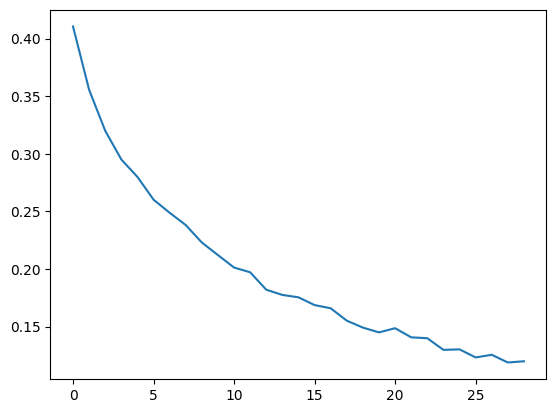

In [12]:
plt.plot(loss_list[1:])

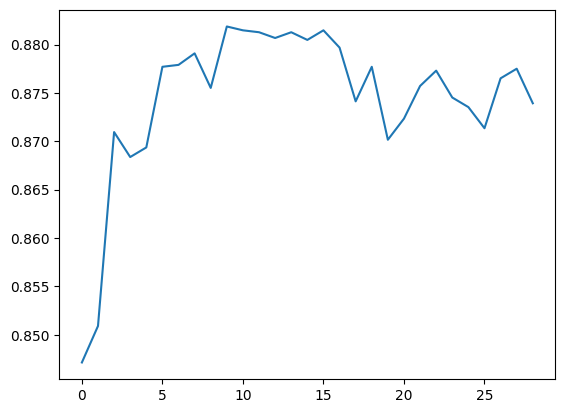

In [13]:
plt.plot(ac_list[1:])

# SELF learning

In [9]:
EPOCH = 30
train_times = 0

loss_list=[]
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    for  _, (inputs, labels) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)

        acc,nce_loss,_ = CPC_model(inputs)

        losses = nce_loss
        losses.backward()
        optimizer.step() 
        running_loss += losses.item()
        count = count+1
    loss_loss = running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)

  3%|██▊                                                                                | 1/30 [00:14<07:08, 14.79s/it]

epoch 1 :finished
train_loss: 0.25173624598189887



  7%|█████▌                                                                             | 2/30 [00:30<07:01, 15.06s/it]

epoch 2 :finished
train_loss: 0.023297725786137747



 10%|████████▎                                                                          | 3/30 [00:44<06:43, 14.95s/it]

epoch 3 :finished
train_loss: 0.022401091194087803



 13%|███████████                                                                        | 4/30 [00:59<06:26, 14.86s/it]

epoch 4 :finished
train_loss: 0.01312403851381194



 17%|█████████████▊                                                                     | 5/30 [01:14<06:09, 14.80s/it]

epoch 5 :finished
train_loss: 0.018252876344828542



 20%|████████████████▌                                                                  | 6/30 [01:28<05:54, 14.76s/it]

epoch 6 :finished
train_loss: 0.011925020268230254



 23%|███████████████████▎                                                               | 7/30 [01:43<05:38, 14.73s/it]

epoch 7 :finished
train_loss: 0.016633578873363756



 27%|██████████████████████▏                                                            | 8/30 [01:58<05:23, 14.72s/it]

epoch 8 :finished
train_loss: 0.006813960576458725



 30%|████████████████████████▉                                                          | 9/30 [02:13<05:10, 14.81s/it]

epoch 9 :finished
train_loss: 0.014542673512723333



 33%|███████████████████████████▎                                                      | 10/30 [02:28<04:58, 14.91s/it]

epoch 10 :finished
train_loss: 0.011415772750523448



 37%|██████████████████████████████                                                    | 11/30 [02:43<04:43, 14.91s/it]

epoch 11 :finished
train_loss: 0.01356516581672776



 40%|████████████████████████████████▊                                                 | 12/30 [02:58<04:26, 14.83s/it]

epoch 12 :finished
train_loss: 0.006385196795788209



 43%|███████████████████████████████████▌                                              | 13/30 [03:12<04:11, 14.78s/it]

epoch 13 :finished
train_loss: 0.01211481846666178



 47%|██████████████████████████████████████▎                                           | 14/30 [03:27<03:55, 14.71s/it]

epoch 14 :finished
train_loss: 0.007716535225369759



 50%|█████████████████████████████████████████                                         | 15/30 [03:41<03:40, 14.73s/it]

epoch 15 :finished
train_loss: 0.012760939308947613



 53%|███████████████████████████████████████████▋                                      | 16/30 [03:56<03:25, 14.70s/it]

epoch 16 :finished
train_loss: 0.00911362772027541



 57%|██████████████████████████████████████████████▍                                   | 17/30 [04:11<03:11, 14.71s/it]

epoch 17 :finished
train_loss: 0.0050406904071712815



 60%|█████████████████████████████████████████████████▏                                | 18/30 [04:26<02:56, 14.71s/it]

epoch 18 :finished
train_loss: 0.015581142103753512



 63%|███████████████████████████████████████████████████▉                              | 19/30 [04:40<02:42, 14.74s/it]

epoch 19 :finished
train_loss: 0.005146353513272578



 67%|██████████████████████████████████████████████████████▋                           | 20/30 [04:55<02:28, 14.80s/it]

epoch 20 :finished
train_loss: 0.010687138711634054



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [05:10<02:13, 14.85s/it]

epoch 21 :finished
train_loss: 0.0056566605814860945



 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [05:25<01:58, 14.79s/it]

epoch 22 :finished
train_loss: 0.018802270517182494



 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [05:40<01:43, 14.79s/it]

epoch 23 :finished
train_loss: 0.006425592568062513



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [05:55<01:28, 14.83s/it]

epoch 24 :finished
train_loss: 0.007509799279442464



 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [06:09<01:13, 14.80s/it]

epoch 25 :finished
train_loss: 0.005541392025919053



 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [06:24<00:59, 14.78s/it]

epoch 26 :finished
train_loss: 0.008046115074023098



 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [06:39<00:44, 14.74s/it]

epoch 27 :finished
train_loss: 0.008656056196761264



 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [06:54<00:29, 14.98s/it]

epoch 28 :finished
train_loss: 0.006775630019888624



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [07:09<00:14, 14.92s/it]

epoch 29 :finished
train_loss: 0.007453002762077393


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [07:24<00:00, 14.81s/it]

epoch 30 :finished
train_loss: 0.008999761140475394


1.0


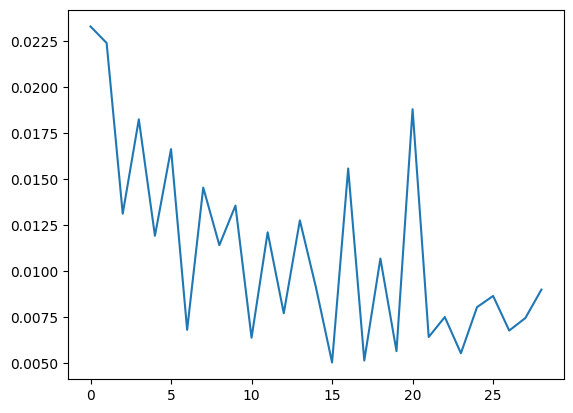

In [10]:
plt.plot(loss_list[1:])
print(acc)

1.0


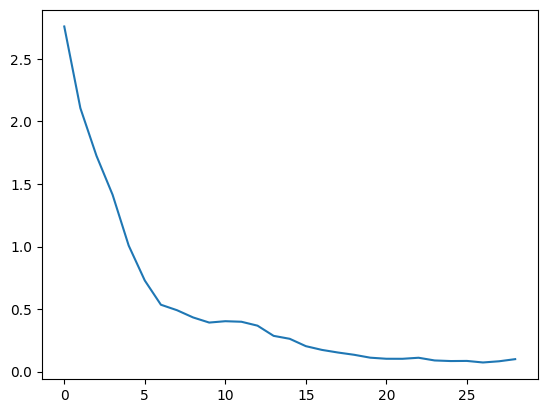

In [7]:
plt.plot(loss_list[1:])
print(acc)